In [72]:
import pandas as pd
df = pd.read_csv('synthetic_telecom_user_data.csv')
df.head()


,user_id,avg_monthly_data_gb,avg_voice_minutes,avg_sms_count,current_plan,plan_cost_inr
0,2001,11.5,971.1,62,DataPlus,399
1,2002,28.5,786.4,95,DataPlus,399
2,2003,22.1,942.5,51,TalkMax,249
3,2004,18.2,900.1,95,UltraMax,599
4,2005,5.1,618.0,131,UltraMax,599


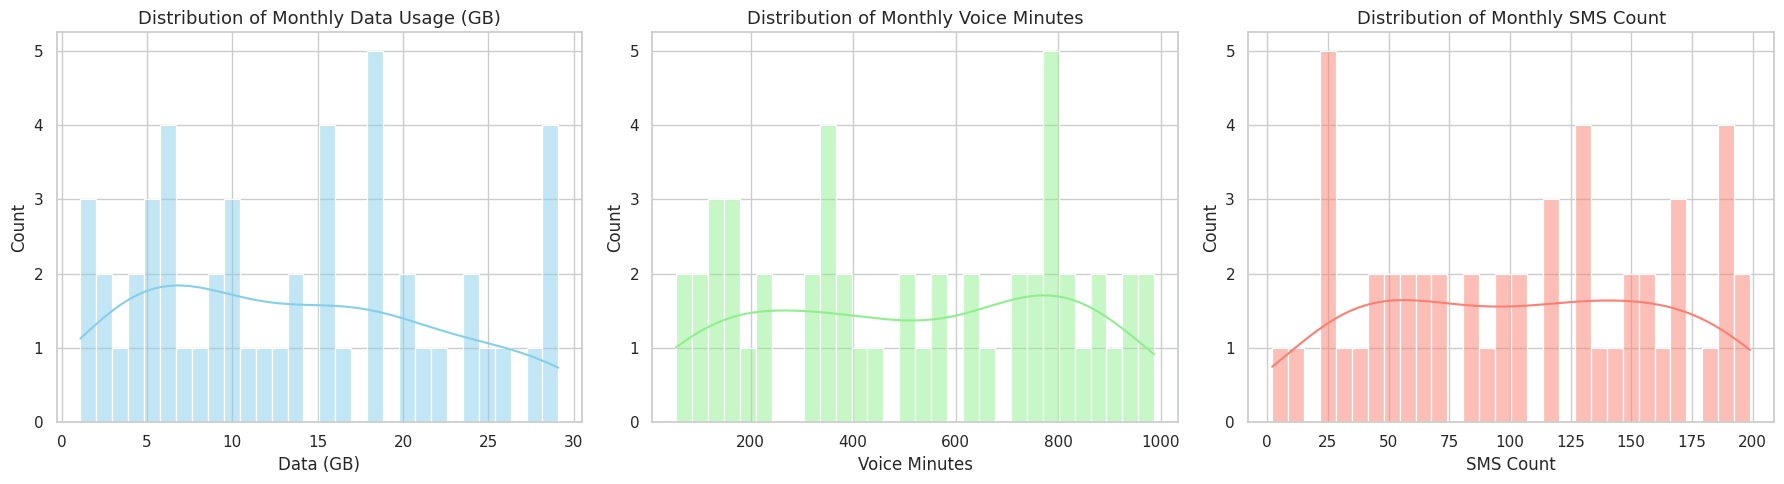

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Data usage distribution
sns.histplot(df['avg_monthly_data_gb'], bins=30, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of Monthly Data Usage (GB)', fontsize=13)
axes[0].set_xlabel('Data (GB)')

# Plot 2: Voice usage distribution
sns.histplot(df['avg_voice_minutes'], bins=30, kde=True, ax=axes[1], color='lightgreen')
axes[1].set_title('Distribution of Monthly Voice Minutes', fontsize=13)
axes[1].set_xlabel('Voice Minutes')

# Plot 3: SMS usage distribution
sns.histplot(df['avg_sms_count'], bins=30, kde=True, ax=axes[2], color='salmon')
axes[2].set_title('Distribution of Monthly SMS Count', fontsize=13)
axes[2].set_xlabel('SMS Count')

# Adjust layout
plt.tight_layout()
plt.show()


In [74]:
from sklearn.preprocessing import StandardScaler

# Select only the usage features
features = ['avg_monthly_data_gb', 'avg_voice_minutes', 'avg_sms_count']
X = df[features]

# Normalize the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [75]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Store metrics for different k values
inertia = []
silhouette_scores = []
K = range(2, 10)

for k in K:
    model = KMeans(n_clusters=k, random_state=42, n_init='auto')
    model.fit(X_scaled)
    inertia.append(model.inertia_)  # Sum of squared distances to cluster centers
    silhouette_scores.append(silhouette_score(X_scaled, model.labels_))


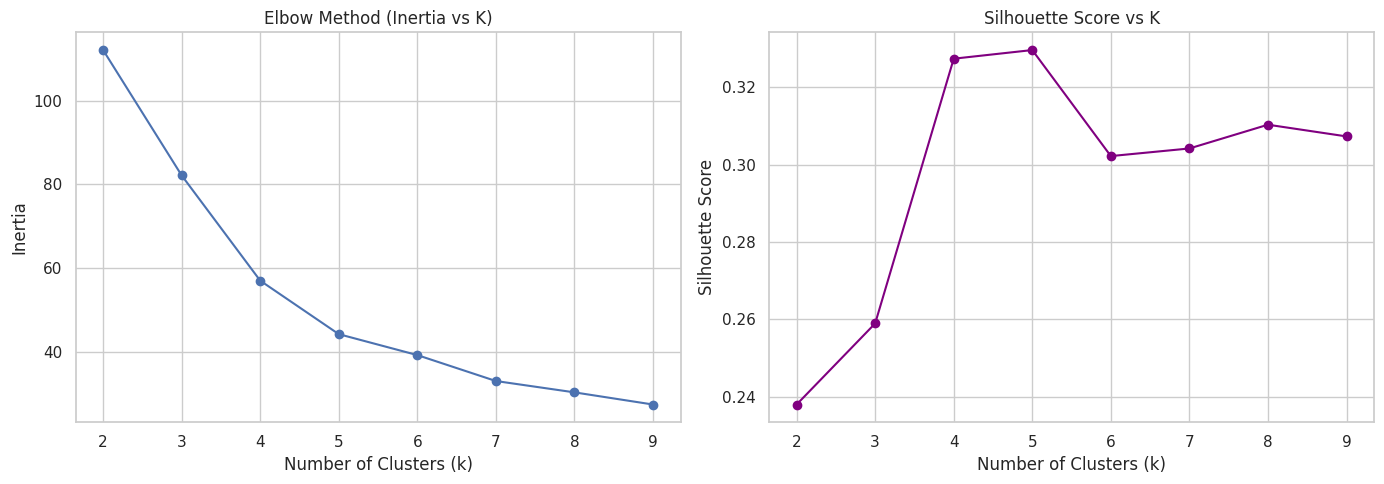

In [76]:
import matplotlib.pyplot as plt

# Plot Elbow and Silhouette Score graphs
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Elbow Curve
ax[0].plot(K, inertia, marker='o')
ax[0].set_title('Elbow Method (Inertia vs K)')
ax[0].set_xlabel('Number of Clusters (k)')
ax[0].set_ylabel('Inertia')

# Silhouette Score
ax[1].plot(K, silhouette_scores, marker='o', color='purple')
ax[1].set_title('Silhouette Score vs K')
ax[1].set_xlabel('Number of Clusters (k)')
ax[1].set_ylabel('Silhouette Score')

plt.tight_layout()
plt.show()


In [77]:
# Choose the best number of clusters (change this if you found a better k)
best_k = 4

# Train the final KMeans model
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
kmeans.fit(X_scaled)

# Assign cluster labels to each user
df['cluster'] = kmeans.labels_

# Show the updated DataFrame
df.head()


,user_id,avg_monthly_data_gb,avg_voice_minutes,avg_sms_count,current_plan,plan_cost_inr,cluster
0,2001,11.5,971.1,62,DataPlus,399,2
1,2002,28.5,786.4,95,DataPlus,399,2
2,2003,22.1,942.5,51,TalkMax,249,2
3,2004,18.2,900.1,95,UltraMax,599,2
4,2005,5.1,618.0,131,UltraMax,599,1


In [78]:
# Group by cluster and show average usage in each
cluster_profiles = df.groupby('cluster')[features].mean().round(2)
cluster_profiles


,avg_monthly_data_gb,avg_voice_minutes,avg_sms_count
cluster,,,
0,11.40,276.53,43.29
1,7.47,580.52,158.19
2,17.62,829.10,76.69
3,24.94,292.51,155.86


In [79]:
# Define plan mapping for each cluster (adjust based on your cluster_profiles output)
cluster_to_plan = {
    0: 'Basic',       # low usage
    1: 'TalkMax',     # high voice
    2: 'DataPlus',    # high data
    3: 'UltraMax'     # all high
}

# Create a new column with the recommended plan based on the cluster
df['recommended_plan'] = df['cluster'].map(cluster_to_plan)

# Preview the recommendation
df[['user_id', 'avg_monthly_data_gb', 'avg_voice_minutes', 'avg_sms_count',
    'current_plan', 'recommended_plan']].head(10)


,user_id,avg_monthly_data_gb,avg_voice_minutes,avg_sms_count,current_plan,recommended_plan
0,2001,11.5,971.1,62,DataPlus,DataPlus
1,2002,28.5,786.4,95,DataPlus,DataPlus
2,2003,22.1,942.5,51,TalkMax,DataPlus
3,2004,18.2,900.1,95,UltraMax,DataPlus
4,2005,5.1,618.0,131,UltraMax,TalkMax
5,2006,5.1,925.8,150,UltraMax,TalkMax
6,2007,2.2,134.1,142,Basic,TalkMax
7,2008,26.1,236.2,170,UltraMax,UltraMax
8,2009,18.2,93.0,28,Basic,Basic
9,2010,21.4,359.1,35,TalkMax,Basic


In [80]:
# How many users should switch plans?
mismatched = df[df['current_plan'] != df['recommended_plan']]
match_count = len(df) - len(mismatched)

print(f"✅ Users already on the right plan: {match_count}")
print(f"❌ Users on a mismatched plan: {len(mismatched)}")

# Show a few examples of mismatched users
mismatched[['user_id', 'avg_monthly_data_gb', 'avg_voice_minutes', 'avg_sms_count',
            'current_plan', 'recommended_plan']].head()


✅ Users already on the right plan: 11
❌ Users on a mismatched plan: 39


,user_id,avg_monthly_data_gb,avg_voice_minutes,avg_sms_count,current_plan,recommended_plan
2,2003,22.1,942.5,51,TalkMax,DataPlus
3,2004,18.2,900.1,95,UltraMax,DataPlus
4,2005,5.1,618.0,131,UltraMax,TalkMax
5,2006,5.1,925.8,150,UltraMax,TalkMax
6,2007,2.2,134.1,142,Basic,TalkMax


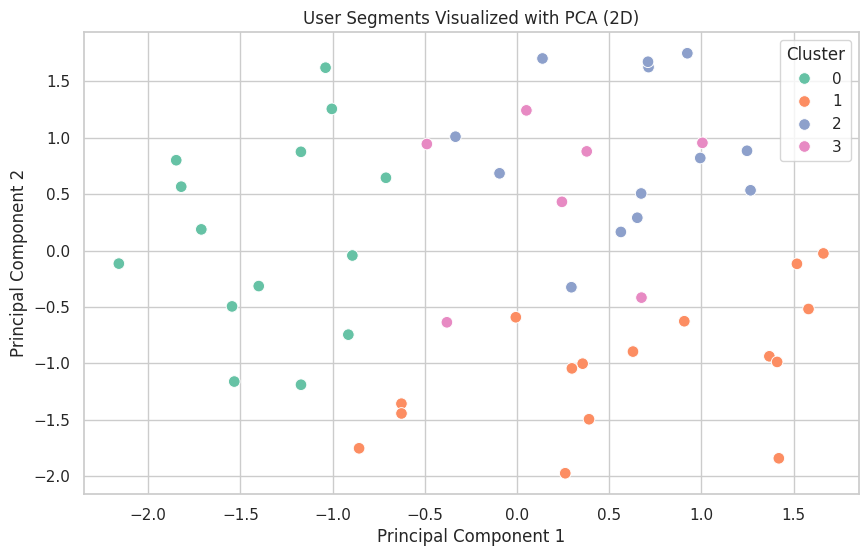

In [81]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Reduce from 3D to 2D using PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add PCA components to the DataFrame
df['pca_1'] = X_pca[:, 0]
df['pca_2'] = X_pca[:, 1]

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='pca_1', y='pca_2', hue='cluster', palette='Set2', s=70)
plt.title('User Segments Visualized with PCA (2D)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


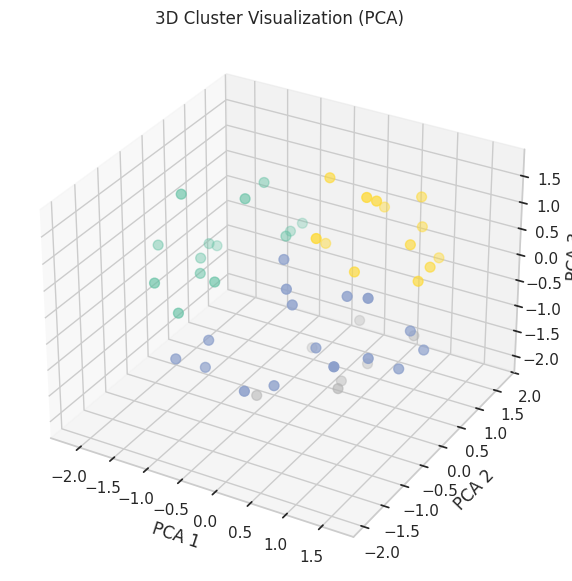

In [82]:
from mpl_toolkits.mplot3d import Axes3D

# Create 3D PCA plot
pca_3d = PCA(n_components=3)
X_3d = pca_3d.fit_transform(X_scaled)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2],
                     c=df['cluster'], cmap='Set2', s=50)

ax.set_title("3D Cluster Visualization (PCA)")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")

plt.show()


In [83]:
!pip install ipywidgets --quiet


In [84]:
import ipywidgets as widgets
from IPython.display import display

# Sliders for user input
data_slider = widgets.FloatSlider(min=0, max=25, step=0.1, value=5, description='Data (GB)')
voice_slider = widgets.IntSlider(min=0, max=1500, step=10, value=300, description='Voice (min)')
sms_slider = widgets.IntSlider(min=0, max=300, step=5, value=50, description='SMS')

# Function to recommend a plan
def recommend_plan(data, voice, sms):
    # Make a DataFrame with input
    input_df = pd.DataFrame([[data, voice, sms]], columns=features)
    input_scaled = scaler.transform(input_df)
    cluster = kmeans.predict(input_scaled)[0]
    plan = cluster_to_plan.get(cluster, "No match")
    print(f"📲 Recommended Plan: {plan} (Cluster {cluster})")

# Interactive widget
ui = widgets.VBox([data_slider, voice_slider, sms_slider])
out = widgets.interactive_output(recommend_plan, {
    'data': data_slider, 'voice': voice_slider, 'sms': sms_slider
})

# Display the UI
display(ui, out)


In [85]:
# Count of users per cluster
cluster_counts = df['cluster'].value_counts().sort_index()

# Savings potential: assume plan prices
plan_prices = {
    'Basic': 149,
    'TalkMax': 249,
    'DataPlus': 399,
    'UltraMax': 599
}

df['recommended_price'] = df['recommended_plan'].map(plan_prices)
df['current_price'] = df['plan_cost_inr']

df['cost_diff'] = df['recommended_price'] - df['current_price']

# Summary metrics
print("📊 User Count per Cluster:\n", cluster_counts)
print("\n💸 Avg Monthly Cost Difference:", round(df['cost_diff'].mean(), 2))
print("📉 Users who are overpaying:", (df['cost_diff'] < 0).sum())
print("📈 Users who can be upsold:", (df['cost_diff'] > 0).sum())


📊 User Count per Cluster:
 cluster
0    14
1    16
2    13
3     7
Name: count, dtype: int64

💸 Avg Monthly Cost Difference: -45.0
📉 Users who are overpaying: 22
📈 Users who can be upsold: 17


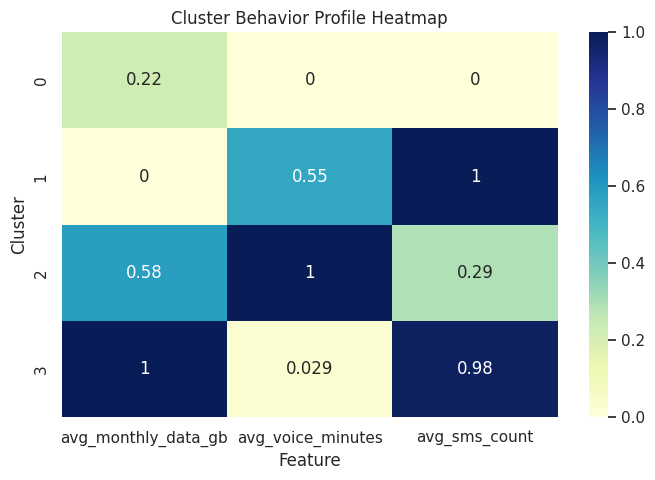

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

# Normalize cluster profile for heatmap
cluster_norm = cluster_profiles.copy()
cluster_norm = (cluster_norm - cluster_norm.min()) / (cluster_norm.max() - cluster_norm.min())

plt.figure(figsize=(8, 5))
sns.heatmap(cluster_norm, annot=True, cmap='YlGnBu')
plt.title('Cluster Behavior Profile Heatmap')
plt.xlabel('Feature')
plt.ylabel('Cluster')
plt.show()


In [87]:
df['usage_mismatch'] = df.apply(lambda row:
    'Upgrade' if row['cost_diff'] > 0 else
    'Downgrade' if row['cost_diff'] < 0 else 'Optimal', axis=1)

df[['user_id', 'current_plan', 'recommended_plan', 'usage_mismatch']].head()


,user_id,current_plan,recommended_plan,usage_mismatch
0,2001,DataPlus,DataPlus,Optimal
1,2002,DataPlus,DataPlus,Optimal
2,2003,TalkMax,DataPlus,Upgrade
3,2004,UltraMax,DataPlus,Downgrade
4,2005,UltraMax,TalkMax,Downgrade


In [88]:
import plotly.express as px
fig = px.scatter_3d(df, x='avg_monthly_data_gb', y='avg_voice_minutes', z='avg_sms_count',
                    color='cluster', hover_data=['user_id', 'recommended_plan'])
fig.show()


In [89]:
!pip install -q google-generativeai

In [90]:
import pandas as pd

In [91]:
import os
import google.generativeai as genai

# Set your Gemini API key
os.environ["GOOGLE_API_KEY"] = "your_api_key_here"

# Configure Gemini
genai.configure(api_key=os.environ["GOOGLE_API_KEY"])

# Create Gemini Flash model
model = genai.GenerativeModel("models/gemini-1.5-flash")


In [92]:
features = ['avg_monthly_data_gb', 'avg_voice_minutes', 'avg_sms_count']


In [93]:
def get_plan_comparison(row):
    # Predict cluster and map to recommended plan
    input_df = pd.DataFrame([[row['avg_monthly_data_gb'],
                               row['avg_voice_minutes'],
                               row['avg_sms_count']]],
                             columns=features)
    input_scaled = scaler.transform(input_df)
    cluster = kmeans.predict(input_scaled)[0]
    recommended_plan = cluster_to_plan[cluster]

    current_plan = row['current_plan'].strip()
    current_cost = row['plan_cost_inr']
    recommended_cost = plan_pricing.get(recommended_plan, 0)
    savings = current_cost - recommended_cost
    savings_pct = round((savings / current_cost) * 100, 1) if current_cost else 0

    return {
        'current_plan': current_plan,
        'current_cost': current_cost,
        'recommended_plan': recommended_plan,
        'recommended_cost': recommended_cost,
        'savings': savings,
        'savings_pct': savings_pct
    }

In [94]:
def generate_plan_explanation(user_profile):
    current_cost = user_profile['current_cost']
    recommended_plan = user_profile['recommended_plan']
    recommended_cost = user_profile['recommended_cost']
    savings = user_profile['savings']
    savings_pct = user_profile['savings_pct']

    if user_profile['current_plan'] == recommended_plan:
        return (
            f"You're already on the {recommended_plan} plan, which suits your monthly usage well! "
            "No need to switch — you're on the right track. 👍"
        )

    if recommended_cost < current_cost:
        return (
            f"The {recommended_plan} plan fits your needs and saves you ₹{savings} every month "
            f"({savings_pct}% less than your current ₹{current_cost} plan). Smart move!"
        )

    # Otherwise, use AI for a nuanced explanation
    prompt = f"""
    A telecom customer has the following monthly usage:
    - Data: {user_profile['avg_monthly_data_gb']} GB
    - Voice: {user_profile['avg_voice_minutes']} minutes
    - SMS: {user_profile['avg_sms_count']}
    Their current plan is {user_profile['current_plan']} at ₹{user_profile['current_cost']}.
    Based on clustering, we recommend the {recommended_plan} plan.

    Please explain (in under 100 words) why this plan is a good fit in a friendly tone.
    """
    response = model.generate_content(prompt)
    return response.text.strip()


In [95]:
import matplotlib.pyplot as plt

def visualize_cost_comparison(current_cost, recommended_cost, recommended_plan):
    if current_cost == recommended_cost:
        print("No cost difference — you're already on the best-priced plan.")
        return

    labels = ['Current Plan', 'Recommended Plan']
    costs = [current_cost, recommended_cost]

    # Decide colors: green if saving, orange if upgrading
    is_upgrade = recommended_cost > current_cost
    colors = ['#ff9999', '#99ff99'] if not is_upgrade else ['#99ccff', '#ffcc99']

    # Plot
    plt.figure(figsize=(6, 4))
    bars = plt.bar(labels, costs, color=colors)
    plt.title("Plan Cost Comparison", fontsize=14)
    plt.ylabel("Monthly Cost (INR)")
    plt.ylim(0, max(costs) + 100)

    # Annotate each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 10,
                 f'₹{int(yval)}', ha='center', va='bottom', fontsize=12)

    # Dynamic message based on direction
    if is_upgrade:
        increase = recommended_cost - current_cost
        plt.text(0.5, max(costs) + 40,
                 f"Spend ₹{increase} more for a better-fit ({recommended_plan}) plan.",
                 ha='center', fontsize=12, color='orange')
    else:
        savings = current_cost - recommended_cost
        savings_pct = round((savings / current_cost) * 100, 1)
        plt.text(0.5, max(costs) + 40,
                 f"Save ₹{savings} ({savings_pct}%) with {recommended_plan}!",
                 ha='center', fontsize=12, color='green')

    plt.tight_layout()
    plt.show()


In [96]:
def simulate_usage_and_explain_from_row(row):
    comparison = get_plan_comparison(row)

    # Include full usage for the explanation
    user_profile = {
        'avg_monthly_data_gb': row['avg_monthly_data_gb'],
        'avg_voice_minutes': row['avg_voice_minutes'],
        'avg_sms_count': row['avg_sms_count'],
        **comparison
    }

    # Generate and display explanation
    explanation = generate_plan_explanation(user_profile)
    print(f"\n📲 Recommended Plan: {comparison['recommended_plan']}")
    print(f"🧠 GPT Explanation:\n{explanation}")

    # Show graph
    visualize_cost_comparison(comparison['current_cost'], comparison['recommended_cost'], comparison['recommended_plan'])


In [97]:
plan_pricing = {
    'Basic': 149,
    'TalkMax': 249,
    'DataPlus': 399,
    'UltraMax': 599
}


📲 Recommended Plan: DataPlus
🧠 GPT Explanation:
Hey there!  Your TalkMax plan is great, but based on your high data usage (23.7GB!), the DataPlus plan might be even better for you.  It's designed for people who need lots of data, so you'll likely get a more value for your money with a plan that better suits your heavy data needs. Let's check out the DataPlus details!


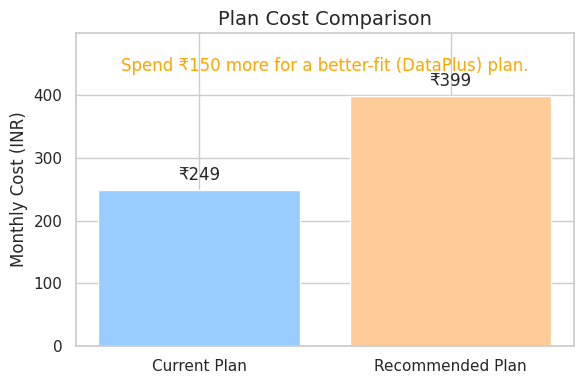

In [98]:
simulate_usage_and_explain_from_row(df.iloc[25])


In [99]:
def identify_upsell_opportunities(df):
    # Flag users underpaying for their high usage
    high_usage_mask = (
        (df['avg_monthly_data_gb'] > df['avg_monthly_data_gb'].median()) &
        (df['avg_voice_minutes'] > df['avg_voice_minutes'].median()) &
        (df['plan_cost_inr'] < df['plan_cost_inr'].median())
    )
    upsell_targets = df[high_usage_mask].copy()
    upsell_targets['suggested_action'] = 'Upsell to higher plan'

    return upsell_targets

def identify_churn_risk_due_to_overpricing(df):
    # Flag users with low usage but high-cost plans
    low_usage_mask = (
        (df['avg_monthly_data_gb'] < df['avg_monthly_data_gb'].median()) &
        (df['avg_voice_minutes'] < df['avg_voice_minutes'].median()) &
        (df['plan_cost_inr'] > df['plan_cost_inr'].median())
    )
    churn_risks = df[low_usage_mask].copy()
    churn_risks['suggested_action'] = 'Risk of churn — downgrade or retention offer'

    return churn_risks

# Apply both
upsell_df = identify_upsell_opportunities(df)
churn_risk_df = identify_churn_risk_due_to_overpricing(df)

# Combine results for operator action
revenue_strategy_df = pd.concat([upsell_df, churn_risk_df]).sort_values(by="plan_cost_inr", ascending=False)
revenue_strategy_df[['avg_monthly_data_gb', 'avg_voice_minutes', 'plan_cost_inr', 'current_plan', 'suggested_action']]


,avg_monthly_data_gb,avg_voice_minutes,plan_cost_inr,current_plan,suggested_action
40,4.1,163.6,599,UltraMax,Risk of churn — downgrade or retention offer
21,4.6,238.8,599,UltraMax,Risk of churn — downgrade or retention offer
13,6.8,388.9,599,UltraMax,Risk of churn — downgrade or retention offer
29,1.9,160.1,399,DataPlus,Risk of churn — downgrade or retention offer
41,15.1,727.6,249,TalkMax,Upsell to higher plan
2,22.1,942.5,249,TalkMax,Upsell to higher plan
25,23.7,742.6,249,TalkMax,Upsell to higher plan
20,18.5,783.6,149,Basic,Upsell to higher plan
30,18.4,869.9,149,Basic,Upsell to higher plan
24,14.0,721.5,149,Basic,Upsell to higher plan


In [100]:
# First add cluster labels to the dataframe
df['cluster'] = kmeans.predict(scaler.transform(df[features]))

# Revenue analysis per cluster
cluster_revenue = df.groupby('cluster').agg(
    total_users=('cluster', 'count'),
    avg_plan_cost=('plan_cost_inr', 'mean'),
    total_revenue=('plan_cost_inr', 'sum')
).sort_values(by='total_revenue', ascending=False)

cluster_revenue['revenue_per_user'] = cluster_revenue['total_revenue'] / cluster_revenue['total_users']
cluster_revenue


,total_users,avg_plan_cost,total_revenue,revenue_per_user
cluster,,,,
1,16,389.625000,6234,389.625000
2,13,352.846154,4587,352.846154
0,14,316.857143,4436,316.857143
3,7,349.000000,2443,349.000000


<Axes: title={'center': 'Total Revenue per Cluster'}, xlabel='cluster'>

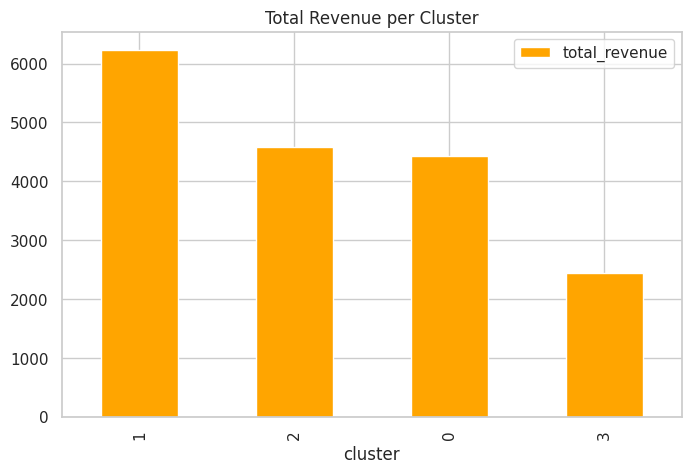

In [101]:
cluster_revenue[['total_revenue']].plot(kind='bar', figsize=(8,5), title="Total Revenue per Cluster", color='orange')


In [102]:
# === Cluster-Level Revenue Dashboard ===

# 1. Add cluster labels to user DataFrame
df['cluster'] = kmeans.predict(scaler.transform(df[features]))

# 2. Cluster revenue summary
cluster_revenue = df.groupby('cluster').agg(
    total_users=('cluster', 'count'),
    avg_plan_cost=('plan_cost_inr', 'mean'),
    total_revenue=('plan_cost_inr', 'sum')
).reset_index()

# 3. Assign strategic labels to clusters
def assign_cluster_action(row):
    if row['avg_plan_cost'] < df['plan_cost_inr'].quantile(0.30) and row['total_users'] > 300:
        return 'Upsell Opportunity'
    elif row['avg_plan_cost'] > df['plan_cost_inr'].quantile(0.70) and row['total_users'] < 150:
        return 'High-Value Retention'
    else:
        return 'Sustain Revenue'

cluster_revenue['cluster_strategy'] = cluster_revenue.apply(assign_cluster_action, axis=1)

# 4. Display strategy table
print("\n📊 Cluster Revenue & Strategy")
display(cluster_revenue.sort_values(by="total_revenue", ascending=False))

# 5. Cluster profiling (avg usage per cluster)
cluster_profile = df.groupby('cluster')[features + ['plan_cost_inr']].mean().round(2)
cluster_profile.columns = ['Avg Data (GB)', 'Avg Voice (min)', 'Avg SMS', 'Avg Plan Cost']
print("\n🔍 Cluster Usage Profiles")
display(cluster_profile)



📊 Cluster Revenue & Strategy


,cluster,total_users,avg_plan_cost,total_revenue,cluster_strategy
1,1,16,389.625000,6234,Sustain Revenue
2,2,13,352.846154,4587,Sustain Revenue
0,0,14,316.857143,4436,Sustain Revenue
3,3,7,349.000000,2443,Sustain Revenue



🔍 Cluster Usage Profiles


,Avg Data (GB),Avg Voice (min),Avg SMS,Avg Plan Cost
cluster,,,,
0,11.40,276.53,43.29,316.86
1,7.47,580.52,158.19,389.62
2,17.62,829.10,76.69,352.85
3,24.94,292.51,155.86,349.00


/tmp/ipython-input-103-2239105115.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




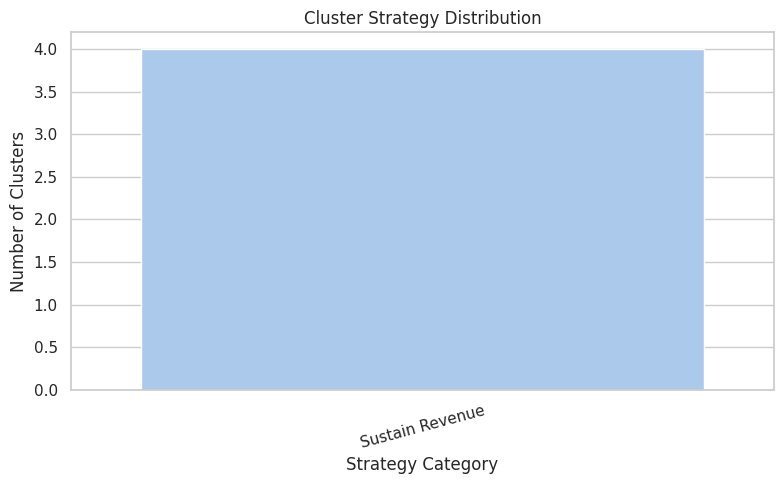

In [103]:
# === 📈 Visual: Cluster Strategy Breakdown ===
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.countplot(data=cluster_revenue, x='cluster_strategy', order=cluster_revenue['cluster_strategy'].value_counts().index, palette='pastel')
plt.title("Cluster Strategy Distribution")
plt.xlabel("Strategy Category")
plt.ylabel("Number of Clusters")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


In [104]:
# === 🔥 Churn Risk Detection Dashboard ===
low_usage_mask = (
    (df['avg_monthly_data_gb'] < df['avg_monthly_data_gb'].median()) &
    (df['avg_voice_minutes'] < df['avg_voice_minutes'].median()) &
    (df['plan_cost_inr'] > df['plan_cost_inr'].median())
)

churn_risk_users = df[low_usage_mask].copy()
churn_risk_users['risk_flag'] = 'High risk of churn'

print(f"⚠️ Identified {len(churn_risk_users)} users with high churn potential")
churn_risk_users.to_csv("churn_risk_users.csv", index=False)
churn_risk_users[['avg_monthly_data_gb', 'avg_voice_minutes', 'plan_cost_inr', 'current_plan', 'risk_flag']].head()


⚠️ Identified 4 users with high churn potential


,avg_monthly_data_gb,avg_voice_minutes,plan_cost_inr,current_plan,risk_flag
13,6.8,388.9,599,UltraMax,High risk of churn
21,4.6,238.8,599,UltraMax,High risk of churn
29,1.9,160.1,399,DataPlus,High risk of churn
40,4.1,163.6,599,UltraMax,High risk of churn


📦 Average Usage by Actual Plan:


,avg_monthly_data_gb,avg_voice_minutes,avg_sms_count,Avg Plan Cost
current_plan,,,,
Basic,11.1,420.6,101.5,149.0
TalkMax,16.5,529.5,93.7,249.0
DataPlus,16.2,562.6,102.2,399.0
UltraMax,11.6,569.7,118.4,599.0


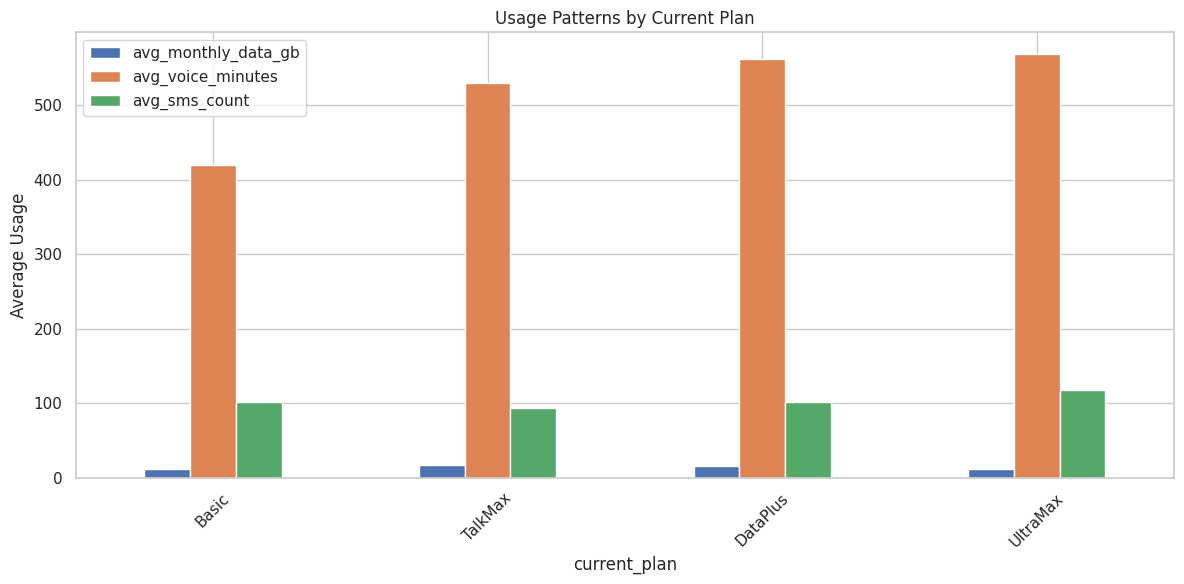

In [105]:
# Map current plans to their prices (if needed)
plan_prices = df.groupby('current_plan')['plan_cost_inr'].mean().to_dict()

# Analyze usage by actual plan
plan_usage_summary = df.groupby('current_plan')[['avg_monthly_data_gb', 'avg_voice_minutes', 'avg_sms_count']].mean().round(1)
plan_usage_summary['Avg Plan Cost'] = df.groupby('current_plan')['plan_cost_inr'].mean().round(0)
plan_usage_summary = plan_usage_summary.sort_values('Avg Plan Cost')

print("📦 Average Usage by Actual Plan:")
display(plan_usage_summary)

# Plot
plan_usage_summary[['avg_monthly_data_gb', 'avg_voice_minutes', 'avg_sms_count']].plot(
    kind='bar',
    figsize=(12, 6),
    title='Usage Patterns by Current Plan'
)
plt.ylabel('Average Usage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [106]:
# === 🌐 Operator-Specific Use Case Notes ===

# Example: Airtel (Premium-Focused)
# - Cluster 1: High ARPU, low user count → retention is key
# - Offer loyalty programs, OTT bundles, priority support

# Example: Jio (Mass Market)
# - Cluster 0: High volume, mid-spend → upsell opportunity
# - Push data boosters, annual bundles
# - Consider launching a new ₹250 plan to bridge Lite & BalancedPlus

# Recommended Campaign Actions:
# - 'Upsell Opportunity' → SMS/push promo for next-tier plans
# - 'High-Value Retention' → Personal contact or digital loyalty offers
# - 'Churn Risk' → Win-back discount or downgrade options
